In [1]:
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 150

rc_fonts = {
    'text.usetex': True,
    'text.latex.preamble': r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
    }
plt.rcParams.update(rc_fonts)

In [3]:
def load_file(f):
    df = pd.read_csv(f,
        delimiter=' ',
        header=None,
        names=['method', 'n', 'time', 'flips'],
        dtype={'method': str, 'n': int, 'time': float, 'flips': int}
        )
    df.method = df.method.str.replace('generate_', '')
    df = df[~df.method.str.contains('_ext')]
    df.loc[df.method.str.contains('gsl_ran'),'method'] = 'gsl'
    df['distribution'] = f
    return df

df = pd.concat([load_file(f) for f in os.listdir() if '@' in f])
df['bits/variate'] = df.flips / df.n
df['variates/sec'] = df.n / df.time
df = df[['distribution', 'method', 'bits/variate', 'variates/sec']]
df = df.sort_values(by=['distribution','method'])

In [4]:
distributions = np.sort(pd.unique(df.distribution))
methods = ['gsl', 'cbs', 'opt']

In [5]:
def get_label(d):
    l = d.split('@')[0]
    l = l.replace('_', ' ')
    if l == 'hypergeometric':
        return 'hypergeom'
    if l == 'negative binomial':
        return 'negbinom'
    return l

In [6]:
def plot_one(metric, ax):
    subdf = df[['distribution', 'method', metric]]
    subdf = subdf.pivot(index='distribution', columns='method', values=metric)
    x = np.arange(len(distributions))
    width = 0.25
    multiplier = 0
    # colors = ['tab:red', 'tab:blue', 'tab:orange']
    for multiplier, method in enumerate(methods):
        measurements = subdf.loc[distributions,method].values
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements, width, label=method.upper(), edgecolor='k')

    ax.grid(which='both', axis='y', alpha=0.1)
    ax.set_axisbelow(True)

    distributions_labels = [get_label(d) for d in distributions]
    xticks = x + width
    ax.set_xticks(xticks, distributions_labels, rotation=90, fontsize=8)
    ax.legend(loc='upper left', ncols=3, fancybox=False)
    ax.set_title(metric)
    ax.set_xlim([min(xticks)-0.5, max(xticks)+0.5])

Text(0.5, 1.0, '')

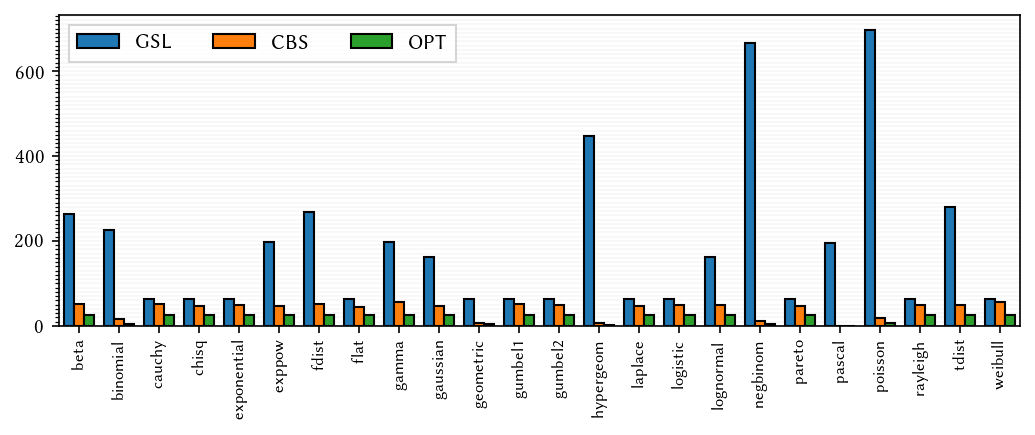

In [7]:
fig, ax = plt.subplots(figsize=(7,3), tight_layout=True)
ax.yaxis.set_minor_locator(plt.matplotlib.ticker.MultipleLocator(10))
plot_one('bits/variate', ax)
ax.set_title('')

(0.0, 1750000.0)

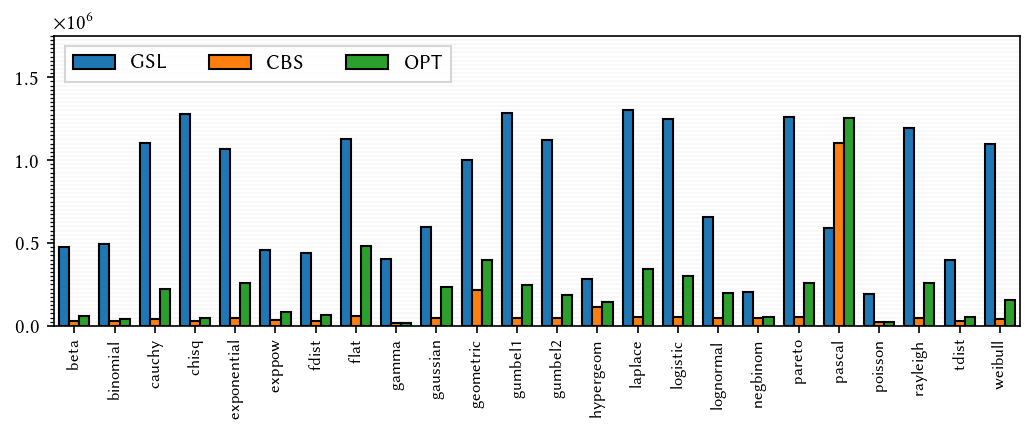

In [8]:
fig, ax = plt.subplots(figsize=(7,3), tight_layout=True)
plot_one('variates/sec', ax)
ax.set_title('')
ax.yaxis.set_minor_locator(plt.matplotlib.ticker.MultipleLocator(1e5/4))
ax.set_ylim([None, 1.75e6])